In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import cv2
import pickle
import random 
import time
import zipfile
from shutil import copyfile
from sklearn.model_selection import train_test_split


In [2]:
# Hoda Dataset Reader
# Python code for reading Hoda farsi digit dataset.

# Hoda Farsi Digit Dataset:
# http://farsiocr.ir/
# http://farsiocr.ir/مجموعه-داده/مجموعه-ارقام-دستنویس-هدی
# http://dadegan.ir/catalog/hoda

# Repository:
# https://github.com/amir-saniyan/HodaDatasetReader

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [3]:
IMG_SIZE=32

In [4]:
X_train, y_train = read_hoda_dataset(dataset_path='../input/persian-numbers/Train 60000.cdb',
                                images_height=IMG_SIZE,
                                images_width=IMG_SIZE,
                                one_hot=False,
                                reshape=True)

X_val = X_train[45000:]
y_val = y_train[45000:]
X_train = X_train[:45000]
y_train = y_train[:45000]


In [5]:
X_test, y_test = read_hoda_dataset(dataset_path='../input/persian-numbers/Test 20000.cdb',
                                images_height=IMG_SIZE,
                                images_width=IMG_SIZE,
                                one_hot=False,
                                reshape=True)

In [6]:
X_train[0].shape

(1024,)

reshape images => (32,32)

In [7]:
X_train = X_train.reshape(X_train.shape[0], IMG_SIZE, IMG_SIZE)
X_test = X_test.reshape(X_test.shape[0], IMG_SIZE,IMG_SIZE)
X_val=X_val.reshape(X_val.shape[0], IMG_SIZE,IMG_SIZE)

In [8]:
X_train[0].shape

(32, 32)

Plot some images to see samples

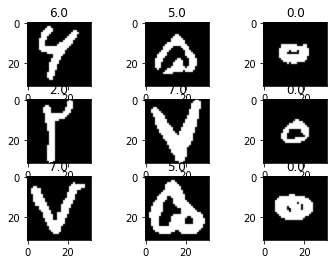

In [9]:
#train samples
for i in range(9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

Preprocessing data

In [10]:
def preprocess_data(X_train, y_train, X_test, y_test,X_val,y_val):
  # reshape images to the required size 
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
  X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)


  
  # convert image values from integers to floats
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  X_val = X_val.astype('float32')


  
#   # normalization
#   X_train = X_train/255.0
#   X_test_norm = X_test/255.0
  
  # One-hot encoding label 
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  y_val = to_categorical(y_val)

  
  return X_train, y_train, X_test, y_test,X_val,y_val

Define Model

In [11]:
def LeNet():
    model = Sequential()

    # Convolutional layer 1
    model.add(Conv2D(64,(5,5),input_shape=(32, 32,1),padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Convolutional layer 2
    model.add(Conv2D(32,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Dropout layer 
    model.add(Dropout(0.25))
    
    # Flatten layer 
    model.add(Flatten()) # 3D feature => 1D feature vector

    # Fully connected layer 1
    model.add(Dense(128, activation='relu'))  
    
    # Fully connected layer 2
    model.add(Dense(64, activation='relu'))  
 

    # The output layer  
    model.add(Dense(10, activation = 'softmax'))

#     opt = SGD(learning_rate = lrate, momentum=0.9, decay=decay, nesterov=False)
    opt = Adam()

    model.compile(loss = 'categorical_crossentropy', 
                    optimizer = opt, 
                    metrics = ['accuracy']) 
    return model


In [12]:
LeNet_model = LeNet()
LeNet_model.summary()

2022-11-19 18:12:32.702621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:12:32.860652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:12:32.861424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:12:32.863278: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 32)          0

2022-11-19 18:12:32.863678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:12:32.864639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:12:32.866647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:12:35.083287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 18:12:35.084177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Training model

In [13]:
def summary_history(history):
  plt.figure(figsize = (10,6))
  plt.plot(history.history['accuracy'], color = 'blue', label = 'train_acc')
  plt.plot(history.history['val_accuracy'], color = 'red', label = 'val_acc')
  plt.legend()
  plt.title('Accuracy')
  plt.show()

def train_model(model, X_train, y_train, X_test, y_test,X_val,y_val, epochs = 30, batch_size = 128):
  # Rescaling all training and testing data
  X_train, y_train, X_test, y_test,X_val,y_val= preprocess_data(X_train, y_train, X_test, y_test,X_val,y_val)
  # Fitting the model on the training set
  history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, 
                      steps_per_epoch = X_train.shape[0]//batch_size, 
                      validation_data = (X_val,y_val), 
                      validation_steps = X_val.shape[0]//batch_size)
  # evaluating the model
  _, acc = model.evaluate(X_test, y_test, verbose = 1)
  print('%.3f' % (acc * 100.0))
  summary_history(history)

2022-11-19 18:12:36.136445: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-11-19 18:12:37.431210: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


351/351 [==============================] - 9s 7ms/step - loss: 0.1618 - accuracy: 0.9526 - val_loss: 0.0403 - val_accuracy: 0.9874
Epoch 2/30
351/351 [==============================] - 2s 6ms/step - loss: 0.0340 - accuracy: 0.9893 - val_loss: 0.0270 - val_accuracy: 0.9911
Epoch 3/30
351/351 [==============================] - 2s 6ms/step - loss: 0.0221 - accuracy: 0.9926 - val_loss: 0.0220 - val_accuracy: 0.9933
Epoch 4/30
351/351 [==============================] - 2s 6ms/step - loss: 0.0183 - accuracy: 0.9936 - val_loss: 0.0193 - val_accuracy: 0.9938
Epoch 5/30
351/351 [==============================] - 2s 6ms/step - loss: 0.0133 - accuracy: 0.9956 - val_loss: 0.0190 - val_accuracy: 0.9949
Epoch 6/30
351/351 [==============================] - 2s 6ms/step - loss: 0.0102 - accuracy: 0.9966 - val_loss: 0.0172 - val_accuracy: 0.9948
Epoch 7/30
351/351 [==============================] - 2s 6ms/step - loss: 0.0096 - accuracy: 0.9969 - val_loss: 0.0171 - val_accuracy: 0.9951
Epoch 8/30
351/35

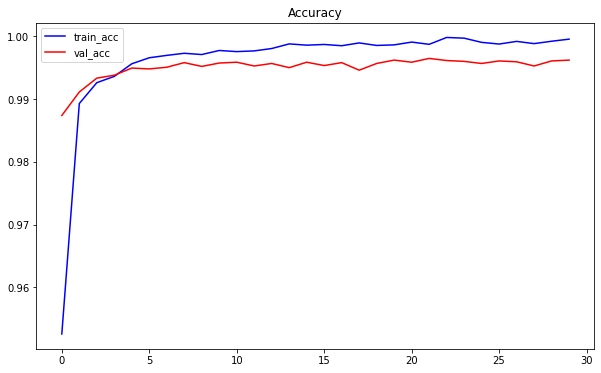

In [14]:
train_model(LeNet_model, X_train, y_train, X_test, y_test,X_val,y_val)